In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.fft
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
X_bs = np.load("bs_FNO_in.npy")
y_bs = np.load("bs_FNO_out.npy")
X_heston = np.load("heston_FNO_in.npy")
y_heston = np.load("heston_FNO_out.npy")

print("Input shape bs:", X_bs.shape)
print("Output shape bs:", y_bs.shape)
print("Input shape heston:", X_heston.shape)
print("Output shape heston:", y_heston.shape)

Input shape bs: (100, 16, 16, 9)
Output shape bs: (100, 16, 16, 1)
Input shape heston: (100, 16, 16, 9)
Output shape heston: (100, 16, 16, 1)


In [4]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(B, self.out_channels, H, W // 2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = torch.einsum(
            "bixy,ioxy->boxy", x_ft[:, :, :self.modes1, :self.modes2], self.weights
        )
        x = torch.fft.irfft2(out_ft, s=(H, W))
        return x

In [13]:
class FNO2d(nn.Module):
    def __init__(self, in_channels, out_channels, width=32, modes1=16, modes2=16):
        super().__init__()
        self.fc0 = nn.Linear(in_channels, width)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)
        self.conv2 = SpectralConv2d(width, width, modes1, modes2)
        self.conv3 = SpectralConv2d(width, width, modes1, modes2)
        self.w = nn.Conv2d(width, width, 1)
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, out_channels)

    def forward(self, x):
        B, H, W, C = x.shape
        x = x.view(B * H * W, C)       # Flatten to (B*H*W, C)
        x = self.fc0(x)                # Apply linear: (B*H*W, width)
        x = x.view(B, H, W, -1)        # Reshape back to (B, H, W, width)
        x = x.permute(0, 3, 1, 2)      # → (B, width, H, W)

        x1 = self.conv1(x); x2 = self.w(x); x = torch.relu(x1 + x2)
        x1 = self.conv2(x); x2 = self.w(x); x = torch.relu(x1 + x2)
        x1 = self.conv3(x); x2 = self.w(x); x = x1 + x2

        x = x.permute(0, 2, 3, 1)      # → (B, H, W, width)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.permute(0, 3, 1, 2)

In [6]:
X_bs_train, X_bs_test, y_bs_train, y_bs_test = train_test_split(X_bs, y_bs, test_size=0.2, random_state=42)

X_bs_train = torch.tensor(X_bs_train, dtype=torch.float32)
y_bs_train = torch.tensor(y_bs_train, dtype=torch.float32)
X_bs_test = torch.tensor(X_bs_test, dtype=torch.float32)
y_bs_test = torch.tensor(y_bs_test, dtype=torch.float32)

X_heston_train, X_heston_test, y_heston_train, y_heston_test = train_test_split(X_heston, y_heston, test_size=0.2, random_state=42)

X_heston_train = torch.tensor(X_heston_train, dtype=torch.float32)
y_heston_train = torch.tensor(y_heston_train, dtype=torch.float32)
X_heston_test = torch.tensor(X_heston_test, dtype=torch.float32)
y_heston_test = torch.tensor(y_heston_test, dtype=torch.float32)

In [7]:
train_bs_dataset = torch.utils.data.TensorDataset(X_bs_train, y_bs_train)
train_bs_loader = torch.utils.data.DataLoader(train_bs_dataset, batch_size=8, shuffle=True)
train_heston_dataset = torch.utils.data.TensorDataset(X_heston_train, y_heston_train)
train_heston_loader = torch.utils.data.DataLoader(train_heston_dataset, batch_size=8, shuffle=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [26]:
model = model = FNO2d(in_channels=9, out_channels=1, width=32, modes1=9, modes2=9).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [27]:
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_bs_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb.permute(0, 3, 1, 2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:02d} - Loss: {total_loss / len(train_bs_loader):.6f}")

Epoch 01 - Loss: 210.078368
Epoch 02 - Loss: 97.580333
Epoch 03 - Loss: 71.163840
Epoch 04 - Loss: 51.230637
Epoch 05 - Loss: 37.104210
Epoch 06 - Loss: 34.630700
Epoch 07 - Loss: 32.493682
Epoch 08 - Loss: 31.038496
Epoch 09 - Loss: 28.969620
Epoch 10 - Loss: 26.336102
Epoch 11 - Loss: 23.326015
Epoch 12 - Loss: 22.297350
Epoch 13 - Loss: 22.143155
Epoch 14 - Loss: 24.449585
Epoch 15 - Loss: 21.582746
Epoch 16 - Loss: 21.212488
Epoch 17 - Loss: 21.103024
Epoch 18 - Loss: 20.702155
Epoch 19 - Loss: 20.337125
Epoch 20 - Loss: 20.259693
Epoch 21 - Loss: 19.374352
Epoch 22 - Loss: 19.207351
Epoch 23 - Loss: 20.184824
Epoch 24 - Loss: 19.401497
Epoch 25 - Loss: 18.966482
Epoch 26 - Loss: 22.758483
Epoch 27 - Loss: 18.995253
Epoch 28 - Loss: 17.210991
Epoch 29 - Loss: 15.829872
Epoch 30 - Loss: 16.071934


In [34]:
model.eval()
with torch.no_grad():
    X_bs_test = X_bs_test.to(device)
    y_bs_test = y_bs_test.to(device)
    preds = model(X_bs_test).cpu().numpy()
    y_true = y_bs_test.cpu().numpy().transpose(0, 3, 1, 2)

# ➗ Flatten for error metrics
y_true_flat = y_true.flatten()
preds_flat = preds.flatten()

mse = mean_squared_error(y_true_flat, preds_flat)
mae = mean_absolute_error(y_true_flat, preds_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, preds_flat)

print(f"\n🔍 Evaluation Metrics:")
print(f"MSE  = {mse:.6f}")
print(f"MAE  = {mae:.6f}")
print(f"RMSE = {rmse:.6f}")
print(f"R²   = {r2:.4f}")


🔍 Evaluation Metrics:
MSE  = 9.905397
MAE  = 2.404408
RMSE = 3.147284
R²   = 0.8222


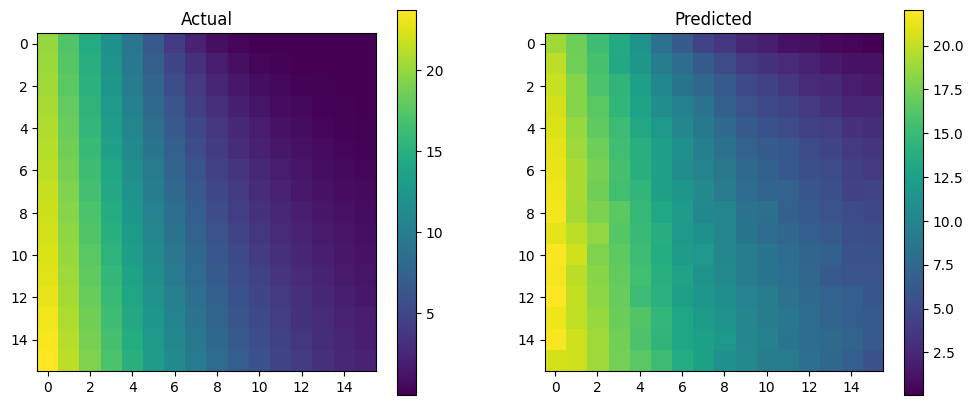

In [35]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_true[0, 0], cmap='viridis')
plt.title("Actual")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(preds[0, 0], cmap='viridis')
plt.title("Predicted")
plt.colorbar()

plt.show()

In [30]:
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_heston_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb.permute(0, 3, 1, 2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:02d} - Loss: {total_loss / len(train_heston_loader):.6f}")

Epoch 01 - Loss: 17.750476
Epoch 02 - Loss: 19.001635
Epoch 03 - Loss: 16.489821
Epoch 04 - Loss: 14.451415
Epoch 05 - Loss: 13.655439
Epoch 06 - Loss: 13.884387
Epoch 07 - Loss: 14.389200
Epoch 08 - Loss: 14.691906
Epoch 09 - Loss: 13.183813
Epoch 10 - Loss: 13.344937
Epoch 11 - Loss: 13.770266
Epoch 12 - Loss: 12.537370
Epoch 13 - Loss: 12.825754
Epoch 14 - Loss: 12.429404
Epoch 15 - Loss: 12.132982
Epoch 16 - Loss: 12.717106
Epoch 17 - Loss: 12.529642
Epoch 18 - Loss: 12.872540
Epoch 19 - Loss: 13.053859
Epoch 20 - Loss: 11.884035
Epoch 21 - Loss: 13.414480
Epoch 22 - Loss: 11.955040
Epoch 23 - Loss: 11.696798
Epoch 24 - Loss: 12.235736
Epoch 25 - Loss: 11.391544
Epoch 26 - Loss: 13.366285
Epoch 27 - Loss: 11.544720
Epoch 28 - Loss: 12.307916
Epoch 29 - Loss: 11.527277
Epoch 30 - Loss: 11.824298


In [31]:
model.eval()
with torch.no_grad():
    X_heston_test = X_heston_test.to(device)
    y_heston_test = y_heston_test.to(device)
    preds = model(X_heston_test).cpu().numpy()
    y_true = y_heston_test.cpu().numpy().transpose(0, 3, 1, 2)

# ➗ Flatten for error metrics
y_true_flat = y_true.flatten()
preds_flat = preds.flatten()

mse = mean_squared_error(y_true_flat, preds_flat)
mae = mean_absolute_error(y_true_flat, preds_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, preds_flat)

print(f"\n🔍 Evaluation Metrics:")
print(f"MSE  = {mse:.6f}")
print(f"MAE  = {mae:.6f}")
print(f"RMSE = {rmse:.6f}")
print(f"R²   = {r2:.4f}")


🔍 Evaluation Metrics:
MSE  = 11.233605
MAE  = 2.613338
RMSE = 3.351657
R²   = 0.7921


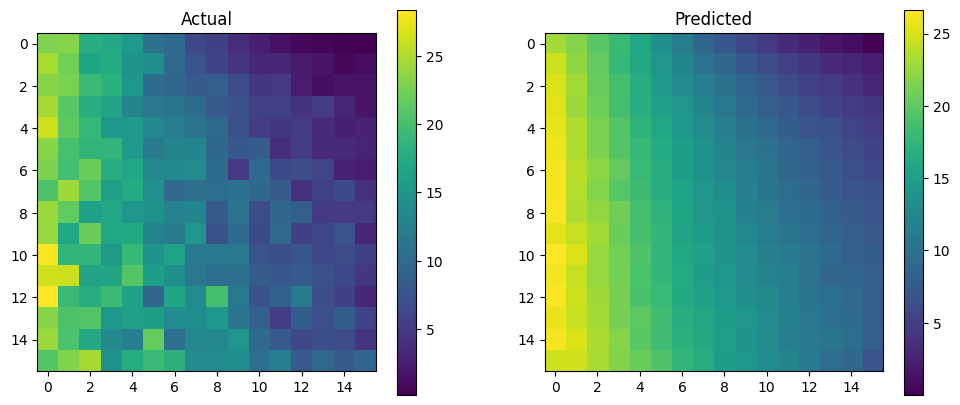

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(y_true[0, 0], cmap='viridis')
plt.title("Actual")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(preds[0, 0], cmap='viridis')
plt.title("Predicted")
plt.colorbar()

plt.show()